In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, SpatialDropout1D, GlobalAveragePooling1D, Layer, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from captum.attr import IntegratedGradients
import requests
import zipfile
import os
import torch
import tensorflow_probability as tfp
from sklearn.metrics import classification_report, confusion_matrix



In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D, GlobalAveragePooling1D, Layer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, TFBertForSequenceClassification
import torch
import lime
import lime.lime_text
from lime.lime_text import LimeTextExplainer
import shap
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
from transformers import pipeline
from tensorflow.keras.models import load_model


In [3]:
# Load data
df = pd.read_csv('Training_Essay_Data.csv', encoding='latin1')




In [4]:
# Data Preprocessing and Cleaning
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text



In [5]:
df['clean_text'] = df['text'].apply(clean_text)



In [6]:
# Tokenization, stopwords removal, and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [7]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens



In [8]:

df['tokens'] = df['clean_text'].apply(preprocess_text)


In [9]:

# Train FastText model
tokenized_sentences = df['tokens'].tolist()
fasttext_model = FastText(vector_size=300, window=5, min_count=1, workers=4)
fasttext_model.build_vocab(corpus_iterable=tokenized_sentences)
fasttext_model.train(corpus_iterable=tokenized_sentences, total_examples=len(tokenized_sentences), epochs=10)


(50501880, 54888100)

In [10]:
# Load GloVe embeddings
def load_glove_embeddings(filepath, embedding_dim=100):
    glove_embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_embeddings[word] = vector
    return glove_embeddings


In [11]:

# URL to the GloVe embeddings
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
filename = 'glove.6B.zip'

# Download the GloVe embeddings
response = requests.get(url)
with open(filename, 'wb') as f:
    f.write(response.content)

# Unzip the file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('glove.6B')

# Path to the specific GloVe file you want to use
glove_filepath = 'glove.6B/glove.6B.100d.txt'

if os.path.exists(glove_filepath):
    glove_embeddings = load_glove_embeddings(glove_filepath, embedding_dim=100)
else:
    print(f"File not found: {glove_filepath}")



In [12]:
# Convert text data into numerical representations: Padding
max_seq_length = 100  # Choose an appropriate sequence length
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
X_seq = tokenizer.texts_to_sequences(df['clean_text'])
X_pad = pad_sequences(X_seq, maxlen=max_seq_length)

# Define features (X) and target variable (y)
X = X_pad
y = df['generated']



In [13]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)



In [14]:

# Define the Attention layer
class Attention(Layer):
    def __init__(self, return_sequences=True):
        super(Attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.activations.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.activations.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return tf.keras.backend.sum(output, axis=1)


In [15]:
# Function to create embedding matrix
def create_embedding_matrix(tokenizer, model, embedding_dim):
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in model.wv:
            embedding_matrix[i] = model.wv[word]
    return embedding_matrix

# Prepare embedding matrices for FastText and GloVe
embedding_matrix_fasttext = create_embedding_matrix(tokenizer, fasttext_model, 300)
embedding_matrix_glove = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove[i] = embedding_vector




In [16]:
# Define LSTM model with embeddings and attention
def create_lstm_model(input_dim, output_dim, max_sequence_length, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim, output_dim, input_length=max_sequence_length,
                        embeddings_initializer=Constant(embedding_matrix),
                        trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Attention(return_sequences=True))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
    return model



In [17]:
# Create LSTM models with different embeddings
lstm_model_fasttext = create_lstm_model(len(tokenizer.word_index) + 1, 300, max_seq_length, embedding_matrix_fasttext)
lstm_model_glove = create_lstm_model(len(tokenizer.word_index) + 1, 100, max_seq_length, embedding_matrix_glove)


C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
# Train the LSTM model with FastText embeddings
history_fasttext = lstm_model_fasttext.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=32)



Epoch 1/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.8090 - auc: 0.8668 - loss: 0.5916 - precision: 0.8729 - recall: 0.5082 - val_accuracy: 0.9366 - val_auc: 0.9789 - val_loss: 0.3918 - val_precision: 0.9790 - val_recall: 0.8451
Epoch 2/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.9294 - auc: 0.9723 - loss: 0.3698 - precision: 0.9528 - recall: 0.8487 - val_accuracy: 0.9541 - val_auc: 0.9851 - val_loss: 0.2836 - val_precision: 0.9575 - val_recall: 0.9155
Epoch 3/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.9430 - auc: 0.9804 - loss: 0.2721 - precision: 0.9618 - recall: 0.8767 - val_accuracy: 0.9522 - val_auc: 0.9863 - val_loss: 0.2125 - val_precision: 0.9856 - val_recall: 0.8824
Epoch 4/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.9533 - auc: 0.9858 - loss: 0.2081 - precision: 0.9634 - recall: 0.9070 - val_accuracy: 0.9660 - val_auc: 0.9893 - val_loss: 0.1716 - val_precision: 0.9664 - val_recall: 0.9399
Epoch 5/40
603/603 ━━━━━

In [19]:
X_train_pad, X_temp_pad, y_train, y_temp = train_test_split(X_pad, y, test_size=0.3, random_state=42)
X_val_pad, X_test_pad, y_val, y_test = train_test_split(X_temp_pad, y_temp, test_size=0.5, random_state=42)

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [21]:
# Evaluate the LSTM model on the test set
y_pred_nn = (lstm_model_fasttext.predict(X_test_pad) > 0.5).astype(int)
print(f"LSTM Model Test Accuracy: {accuracy_score(y_test, y_pred_nn):.2f}")
print(classification_report(y_test, y_pred_nn))


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
LSTM Model Test Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2608
           1       0.97      0.98      0.98      1523

    accuracy                           0.98      4131
   macro avg       0.98      0.98      0.98      4131
weighted avg       0.98      0.98      0.98      4131



In [22]:
# Evaluate the LSTM model on the test set
y_pred_nn = (lstm_model_fasttext.predict(X_test_pad) > 0.5).astype(int)
print(f"LSTM Model Test Accuracy: {accuracy_score(y_test, y_pred_nn):.2f}")
print(classification_report(y_test, y_pred_nn))

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
LSTM Model Test Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2608
           1       0.97      0.98      0.98      1523

    accuracy                           0.98      4131
   macro avg       0.98      0.98      0.98      4131
weighted avg       0.98      0.98      0.98      4131



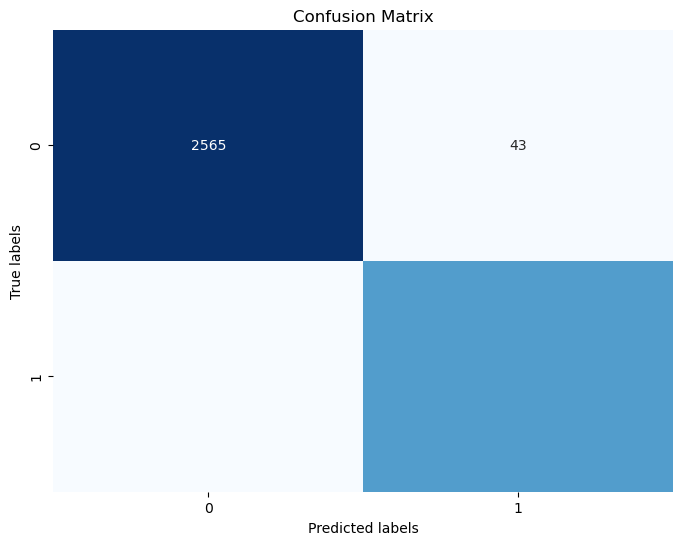

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


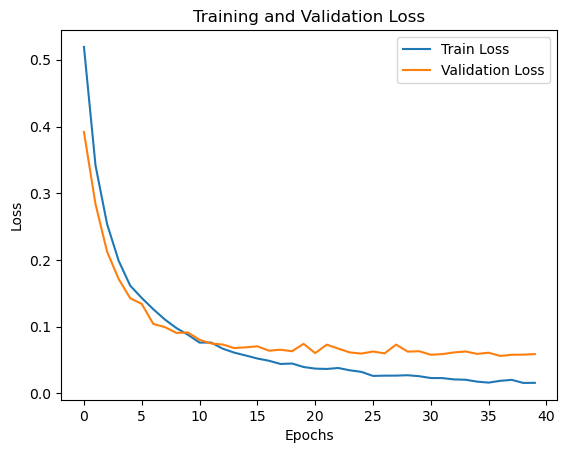

In [24]:
# Plot training history
plt.plot(history_fasttext.history['loss'], label='Train Loss')
plt.plot(history_fasttext.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [25]:
# ROC-AUC
test_loss, test_acc, test_recall, test_precision, test_auc = lstm_model_fasttext.evaluate(X_test_pad, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test AUC:", test_auc)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9851 - auc: 0.9966 - loss: 0.0520 - precision: 0.9767 - recall: 0.9825
Test Loss: 0.05845059081912041
Test Accuracy: 0.9820866584777832
Test Recall: 0.9719869494438171
Test Precision: 0.9796454310417175
Test AUC: 0.9964559674263


In [26]:
y_pred_proba = lstm_model_fasttext.predict(X_test_pad)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)
print("Test ROC-AUC:", roc_auc_value)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Test ROC-AUC: 0.9977598097071891


In [27]:
lstm_model_fasttext.save('lstm_model_fasttext_FINAL00.h5')

In [28]:
import keras

In [29]:
keras.saving.save_model(lstm_model_fasttext, 'lstm_model_fasttext_FINAL0.keras')

In [30]:
import shap
import numpy as np

In [31]:
# Example: Assuming X_shap is a subset of your validation data
X_shap = X_val[:100]  # Selecting first 100 examples for explanation (adjust as needed)


In [32]:
# Example: Wrap your model with a function for SHAP compatibility
def model_wrapper(x):
    # Adjust x if needed (e.g., reshape for LSTM input)
    return lstm_model_fasttext.predict(x)

explainer = shap.Explainer(model_wrapper, X_shap)


In [33]:
shap_values = explainer(X_shap)


616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step


PermutationExplainer explainer:   1%|▌                                                         | 1/100 [00:00<?, ?it/s]

617/617 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:   3%|█▌                                                | 3/100 [00:48<19:57, 12.34s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


PermutationExplainer explainer:   4%|██                                                | 4/100 [01:13<28:05, 17.56s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:   5%|██▌                                               | 5/100 [01:37<31:52, 20.13s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:   6%|███                                               | 6/100 [02:01<33:36, 21.45s/it]

618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


PermutationExplainer explainer:   7%|███▌                                              | 7/100 [02:26<34:42, 22.39s/it]

618/618 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
618/618 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:   8%|████                                              | 8/100 [02:50<35:26, 23.12s/it]

619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:   9%|████▌                                             | 9/100 [03:14<35:29, 23.40s/it]

615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  10%|████▉                                            | 10/100 [03:39<35:37, 23.75s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


PermutationExplainer explainer:  11%|█████▍                                           | 11/100 [04:03<35:21, 23.84s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


PermutationExplainer explainer:  12%|█████▉                                           | 12/100 [04:27<35:10, 23.98s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  13%|██████▎                                          | 13/100 [04:52<34:56, 24.10s/it]

619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  14%|██████▊                                          | 14/100 [05:16<34:39, 24.17s/it]

619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


PermutationExplainer explainer:  15%|███████▎                                         | 15/100 [05:40<34:20, 24.24s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  16%|███████▊                                         | 16/100 [06:04<33:52, 24.20s/it]

615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  17%|████████▎                                        | 17/100 [06:29<33:26, 24.18s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  18%|████████▊                                        | 18/100 [06:53<33:10, 24.27s/it]

619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  19%|█████████▎                                       | 19/100 [07:17<32:48, 24.31s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  20%|█████████▊                                       | 20/100 [07:42<32:30, 24.38s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


PermutationExplainer explainer:  21%|██████████▎                                      | 21/100 [08:07<32:17, 24.52s/it]

618/618 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
618/618 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


PermutationExplainer explainer:  22%|██████████▊                                      | 22/100 [08:31<31:55, 24.56s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  23%|███████████▎                                     | 23/100 [08:56<31:19, 24.41s/it]

618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  24%|███████████▊                                     | 24/100 [09:20<30:52, 24.37s/it]

615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  25%|████████████▎                                    | 25/100 [09:45<30:36, 24.48s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  26%|████████████▋                                    | 26/100 [10:09<30:03, 24.37s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  27%|█████████████▏                                   | 27/100 [10:34<29:50, 24.53s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  28%|█████████████▋                                   | 28/100 [10:58<29:14, 24.37s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  29%|██████████████▏                                  | 29/100 [11:21<28:39, 24.21s/it]

615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  30%|██████████████▋                                  | 30/100 [11:45<28:11, 24.17s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  31%|███████████████▏                                 | 31/100 [12:10<27:45, 24.14s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  32%|███████████████▋                                 | 32/100 [12:34<27:26, 24.21s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  33%|████████████████▏                                | 33/100 [12:58<26:58, 24.15s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  34%|████████████████▋                                | 34/100 [13:22<26:28, 24.07s/it]

619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  35%|█████████████████▏                               | 35/100 [13:46<26:14, 24.22s/it]

615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  36%|█████████████████▋                               | 36/100 [14:10<25:42, 24.10s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  37%|██████████████████▏                              | 37/100 [14:34<25:20, 24.14s/it]

621/621 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  38%|██████████████████▌                              | 38/100 [14:59<24:55, 24.12s/it]

618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  39%|███████████████████                              | 39/100 [15:23<24:28, 24.08s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  40%|███████████████████▌                             | 40/100 [15:46<23:59, 24.00s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  41%|████████████████████                             | 41/100 [16:10<23:30, 23.91s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  42%|████████████████████▌                            | 42/100 [16:34<23:13, 24.02s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  43%|█████████████████████                            | 43/100 [16:58<22:47, 24.00s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  44%|█████████████████████▌                           | 44/100 [17:22<22:21, 23.96s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  45%|██████████████████████                           | 45/100 [17:46<22:00, 24.02s/it]

618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  46%|██████████████████████▌                          | 46/100 [18:10<21:31, 23.92s/it]

619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


PermutationExplainer explainer:  47%|███████████████████████                          | 47/100 [18:34<21:10, 23.97s/it]

618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  48%|███████████████████████▌                         | 48/100 [18:58<20:44, 23.94s/it]

618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  49%|████████████████████████                         | 49/100 [19:22<20:20, 23.92s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  50%|████████████████████████▌                        | 50/100 [19:46<20:04, 24.09s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  51%|████████████████████████▉                        | 51/100 [20:10<19:36, 24.00s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  52%|█████████████████████████▍                       | 52/100 [20:34<19:14, 24.05s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  53%|█████████████████████████▉                       | 53/100 [20:58<18:50, 24.06s/it]

615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  54%|██████████████████████████▍                      | 54/100 [21:22<18:19, 23.91s/it]

618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  55%|██████████████████████████▉                      | 55/100 [21:46<17:57, 23.95s/it]

620/620 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  56%|███████████████████████████▍                     | 56/100 [22:10<17:32, 23.93s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  57%|███████████████████████████▉                     | 57/100 [22:34<17:09, 23.95s/it]

618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  58%|████████████████████████████▍                    | 58/100 [22:58<16:45, 23.93s/it]

618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  59%|████████████████████████████▉                    | 59/100 [23:22<16:19, 23.90s/it]

618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
618/618 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  60%|█████████████████████████████▍                   | 60/100 [23:46<15:59, 24.00s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  61%|█████████████████████████████▉                   | 61/100 [24:09<15:32, 23.91s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  62%|██████████████████████████████▍                  | 62/100 [24:33<15:09, 23.94s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  63%|██████████████████████████████▊                  | 63/100 [24:58<14:47, 23.99s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  64%|███████████████████████████████▎                 | 64/100 [25:21<14:20, 23.90s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  65%|███████████████████████████████▊                 | 65/100 [25:45<13:55, 23.88s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  66%|████████████████████████████████▎                | 66/100 [26:09<13:31, 23.87s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  67%|████████████████████████████████▊                | 67/100 [26:33<13:10, 23.96s/it]

620/620 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  68%|█████████████████████████████████▎               | 68/100 [26:57<12:48, 24.01s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  69%|█████████████████████████████████▊               | 69/100 [27:21<12:25, 24.04s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  70%|██████████████████████████████████▎              | 70/100 [27:45<12:01, 24.04s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  71%|██████████████████████████████████▊              | 71/100 [28:09<11:37, 24.05s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


PermutationExplainer explainer:  72%|███████████████████████████████████▎             | 72/100 [28:34<11:16, 24.18s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  73%|███████████████████████████████████▊             | 73/100 [28:58<10:52, 24.16s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  74%|████████████████████████████████████▎            | 74/100 [29:22<10:25, 24.05s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  75%|████████████████████████████████████▊            | 75/100 [29:46<09:58, 23.93s/it]

613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  76%|█████████████████████████████████████▏           | 76/100 [30:09<09:34, 23.94s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  77%|█████████████████████████████████████▋           | 77/100 [30:33<09:11, 23.96s/it]

619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  78%|██████████████████████████████████████▏          | 78/100 [30:58<08:49, 24.07s/it]

620/620 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  79%|██████████████████████████████████████▋          | 79/100 [31:22<08:26, 24.10s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  80%|███████████████████████████████████████▏         | 80/100 [31:46<08:01, 24.07s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  81%|███████████████████████████████████████▋         | 81/100 [32:10<07:37, 24.06s/it]

618/618 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  82%|████████████████████████████████████████▏        | 82/100 [32:34<07:13, 24.10s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  83%|████████████████████████████████████████▋        | 83/100 [32:58<06:49, 24.10s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  84%|█████████████████████████████████████████▏       | 84/100 [33:22<06:24, 24.05s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  85%|█████████████████████████████████████████▋       | 85/100 [33:46<06:00, 24.06s/it]

619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  86%|██████████████████████████████████████████▏      | 86/100 [34:11<05:38, 24.15s/it]

614/614 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
614/614 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  87%|██████████████████████████████████████████▋      | 87/100 [34:34<05:12, 24.04s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  88%|███████████████████████████████████████████      | 88/100 [34:58<04:48, 24.01s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  89%|███████████████████████████████████████████▌     | 89/100 [35:23<04:24, 24.07s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


PermutationExplainer explainer:  90%|████████████████████████████████████████████     | 90/100 [35:47<04:01, 24.12s/it]

619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  91%|████████████████████████████████████████████▌    | 91/100 [36:11<03:37, 24.15s/it]

620/620 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  92%|█████████████████████████████████████████████    | 92/100 [36:35<03:13, 24.19s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  93%|█████████████████████████████████████████████▌   | 93/100 [36:59<02:49, 24.14s/it]

615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  94%|██████████████████████████████████████████████   | 94/100 [37:23<02:24, 24.12s/it]

618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  95%|██████████████████████████████████████████████▌  | 95/100 [37:47<02:00, 24.03s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  96%|███████████████████████████████████████████████  | 96/100 [38:11<01:36, 24.01s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  97%|███████████████████████████████████████████████▌ | 97/100 [38:35<01:12, 24.00s/it]

619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  98%|████████████████████████████████████████████████ | 98/100 [39:00<00:48, 24.08s/it]

617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:  99%|████████████████████████████████████████████████▌| 99/100 [39:23<00:24, 24.05s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


PermutationExplainer explainer: 100%|████████████████████████████████████████████████| 100/100 [39:48<00:00, 24.18s/it]

616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer: 101it [40:12, 24.13s/it]                                                               


In [34]:
# Convert dict_keys object to a list
feature_names_list = list(tokenizer.word_index.keys())


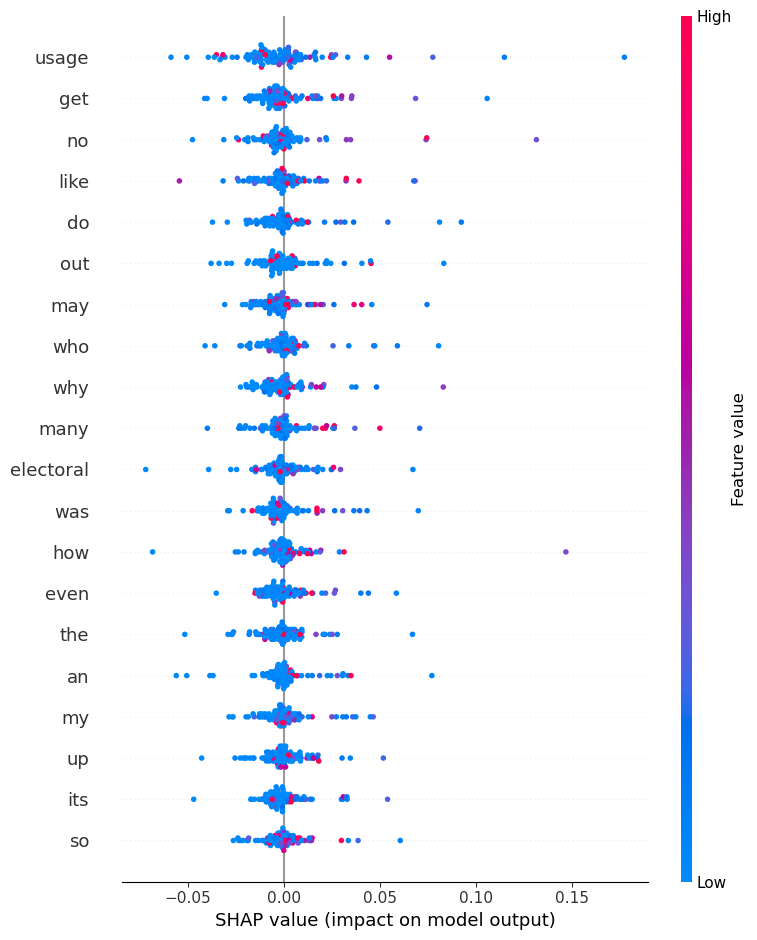

In [35]:
# Example: Summary plot of SHAP values
shap.summary_plot(shap_values, X_shap, feature_names=feature_names_list)


In [36]:
import lime
import lime.lime_text
from keras.preprocessing.sequence import pad_sequences
import numpy as np


In [37]:
# Prepare text data for LIME
def prepare_text_for_lime(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)
    return padded_sequences

In [38]:

explainer = lime.lime_text.LimeTextExplainer()


In [39]:
idx = 0  # Change this index to select different examples

In [40]:
X_explain_text = df['clean_text'].iloc[idx]  # Adjust as per your data structure
X_explain = prepare_text_for_lime([X_explain_text])


In [41]:
def predict_fn(texts):
    # Assuming bayesian_lstm_model_word2vec is your Keras model
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)
    return lstm_model_fasttext.predict(padded_sequences)



In [42]:
# Example usage
#explanation = explainer.explain_instance(X_explain_text, predict_fn, num_features=10)


In [43]:
#explanation.show_in_notebook(text=True)


In [44]:
import lime
import lime.lime_text
from lime.lime_text import LimeTextExplainer

In [45]:
# LIME
explainer = LimeTextExplainer(class_names=['Non Generated', 'Generated'])
idx = 0
sample_text = df['clean_text'].iloc[idx]


In [46]:
def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    return np.array([[1-p, p] for p in lstm_model_fasttext.predict(padded).flatten()])



In [47]:
input_dim = len(tokenizer.word_index) + 1
output_dim = 100
max_sequence_length = X_pad.shape[1]

In [48]:
exp = explainer.explain_instance(sample_text, predict_proba, num_features=10)
exp.show_in_notebook(text=sample_text)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [49]:
text_to_explain = df['clean_text'].iloc[idx]

In [50]:
# Choose an example text to explain
idx = 0  # Change this index to select different examples
text_to_explain = df['clean_text'].iloc[idx]
true_label = df['generated'].iloc[idx]


In [51]:
# For terminal visualization
print('Document id: %d' % idx)
print('Probability(G):', predict_proba([text_to_explain])[0, 1])
print('True class: %s' % true_label)
exp.show_in_notebook(text=True)



Document id: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Probability(G): 0.9998642802238464
True class: 1


In [52]:
# Function to predict probabilities for LIME explainer
def predict_proba(texts):
    seq = tokenizer.texts_to_sequences(texts)
    padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_sequence_length)
    preds = lstm_model_fasttext.predict(padded)
    return np.hstack((1 - preds, preds))


In [53]:
# Initialize LIME text explainer
explainer = LimeTextExplainer(class_names=['Non Generated', 'Generated'])



In [54]:
# Choose an example text to explain
idx = 0  # Change this index to select different examples
text_to_explain = df['clean_text'].iloc[idx]
true_label = df['generated'].iloc[idx]



In [55]:
# Explain the prediction of the example text
exp = explainer.explain_instance(text_to_explain, predict_proba, num_features=10)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [56]:
# Visualize the explanation
exp.show_in_notebook(text=True)


In [57]:
# For terminal visualization
print('Document id: %d' % idx)
print('Probability(G):', predict_proba([text_to_explain])[0, 1])
print('True class: %s' % true_label)
exp.show_in_notebook(text=True)


Document id: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Probability(G): 0.9998643
True class: 1


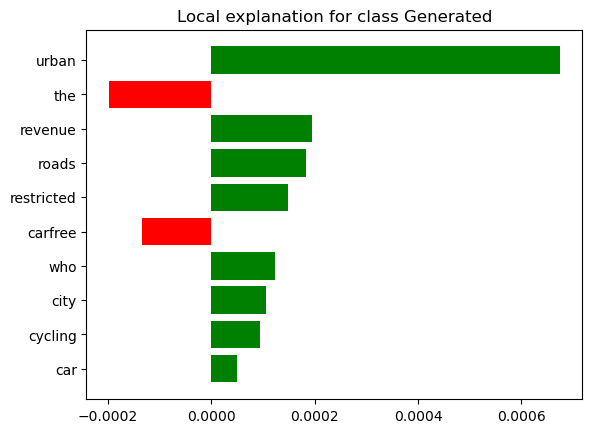

In [58]:
# Plot LIME explanations as a bar chart
fig = exp.as_pyplot_figure()
plt.show()

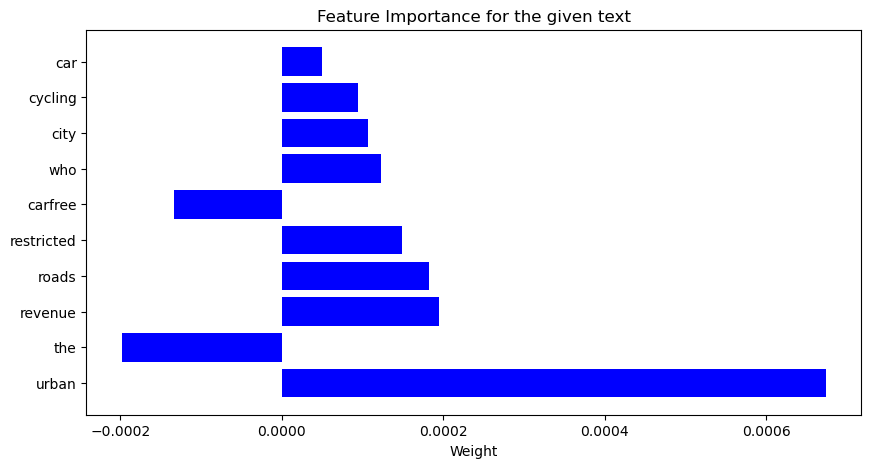

In [59]:
# 1. Feature Importance Bar Chart
plt.figure(figsize=(10, 5))
exp.as_list()
weights = dict(exp.as_list())
plt.barh(list(weights.keys()), list(weights.values()), color='b')
plt.xlabel('Weight')
plt.title('Feature Importance for the given text')
plt.show()



157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


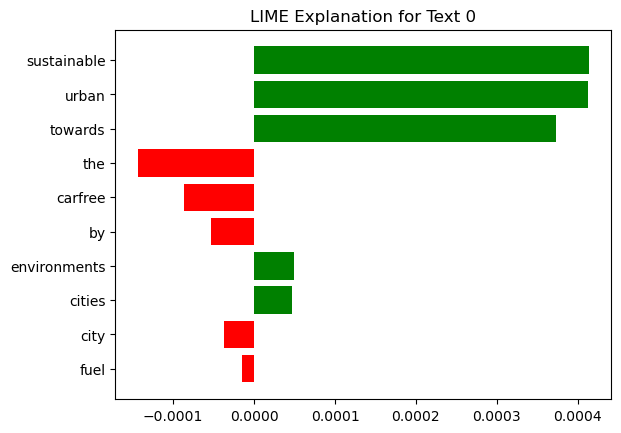

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


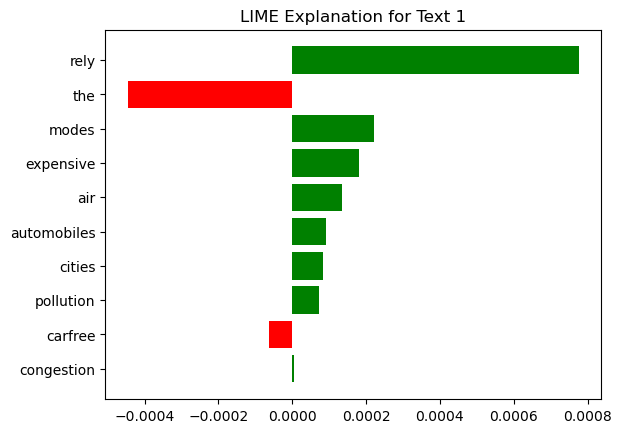

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


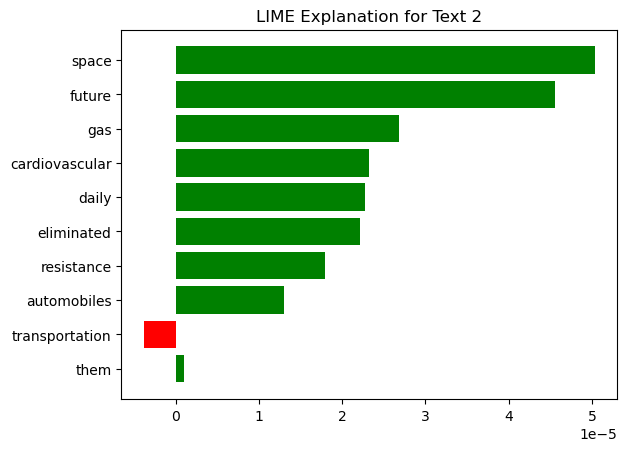

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


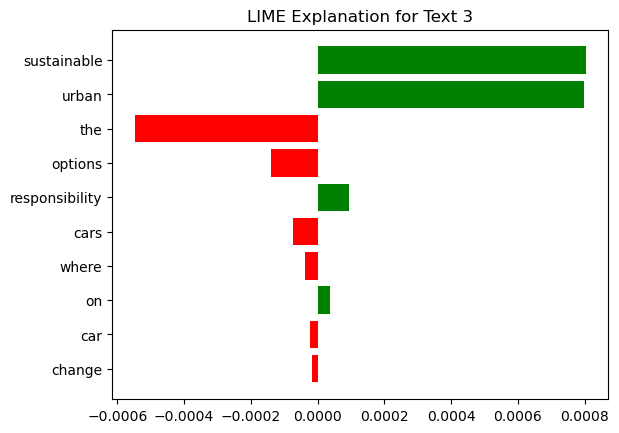

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


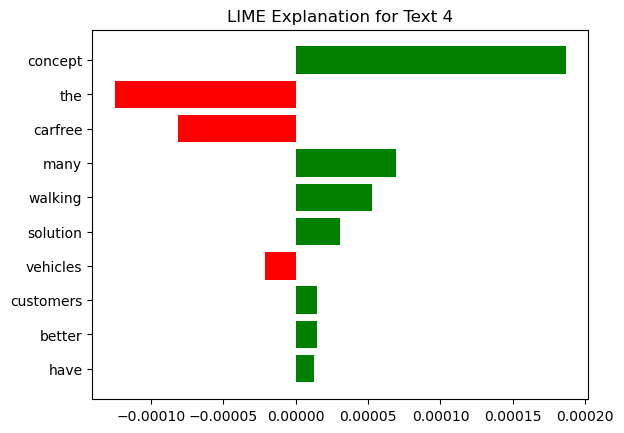

In [60]:
# 3. Comparison of Predictions for Multiple Texts
texts_to_explain = df['clean_text'].iloc[:5]  # Change to select different examples
for i, text in enumerate(texts_to_explain):
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    fig = exp.as_pyplot_figure()
    plt.title(f'LIME Explanation for Text {i}')
    plt.show()

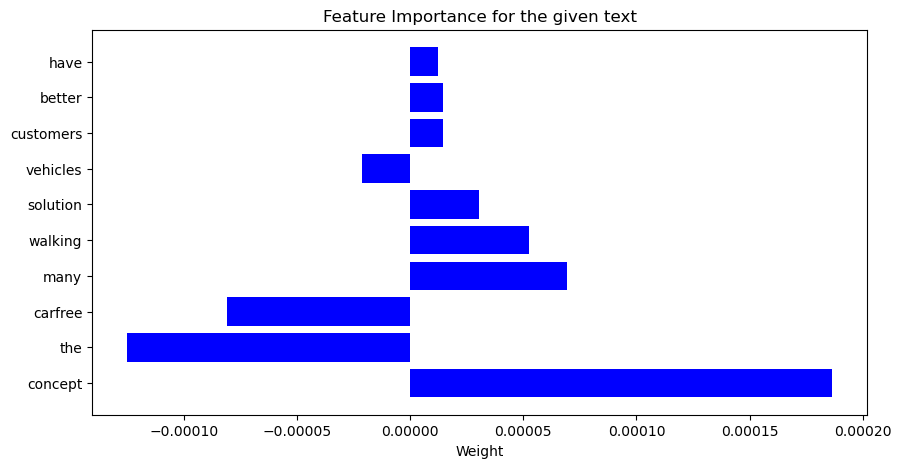

In [61]:
# Additional Visualizations

# 1. Feature Importance Bar Chart
plt.figure(figsize=(10, 5))
exp.as_list()
weights = dict(exp.as_list())
plt.barh(list(weights.keys()), list(weights.values()), color='b')
plt.xlabel('Weight')
plt.title('Feature Importance for the given text')
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


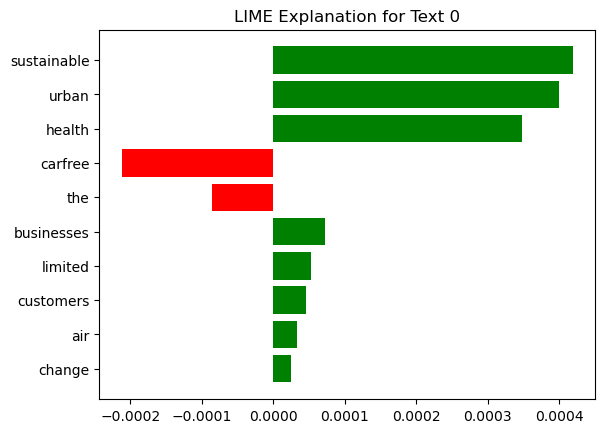

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


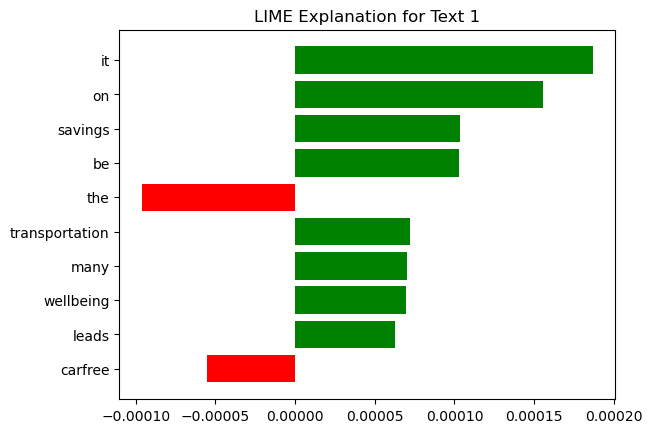

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


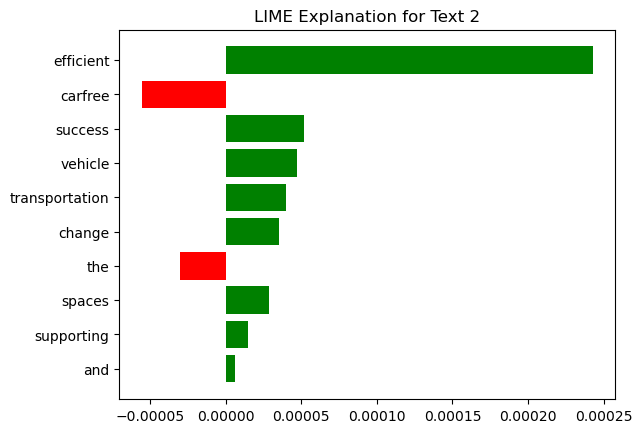

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


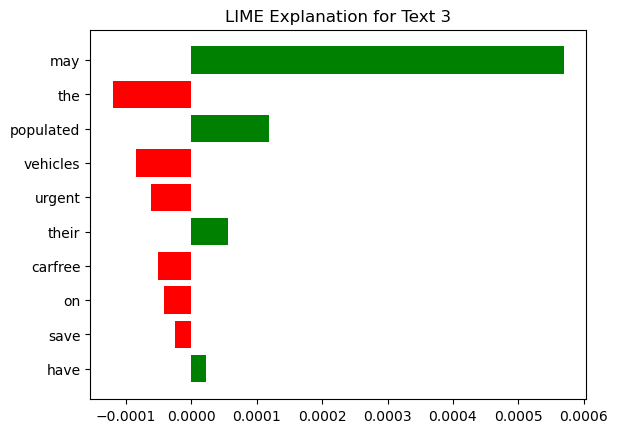

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


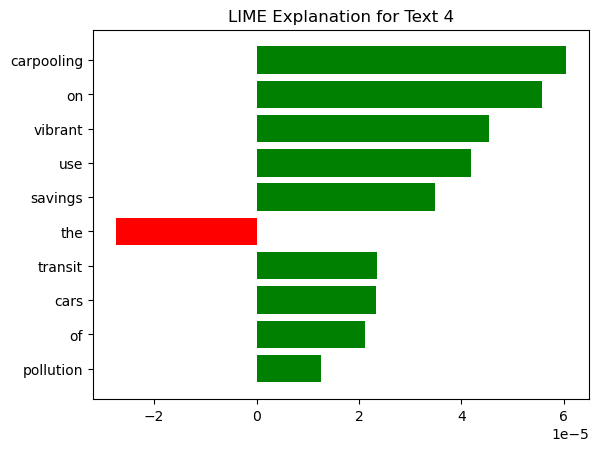

In [62]:
# 3. Comparison of Predictions for Multiple Texts
texts_to_explain = df['clean_text'].iloc[:5]  # Change to select different examples
for i, text in enumerate(texts_to_explain):
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    fig = exp.as_pyplot_figure()
    plt.title(f'LIME Explanation for Text {i}')
    plt.show()



130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


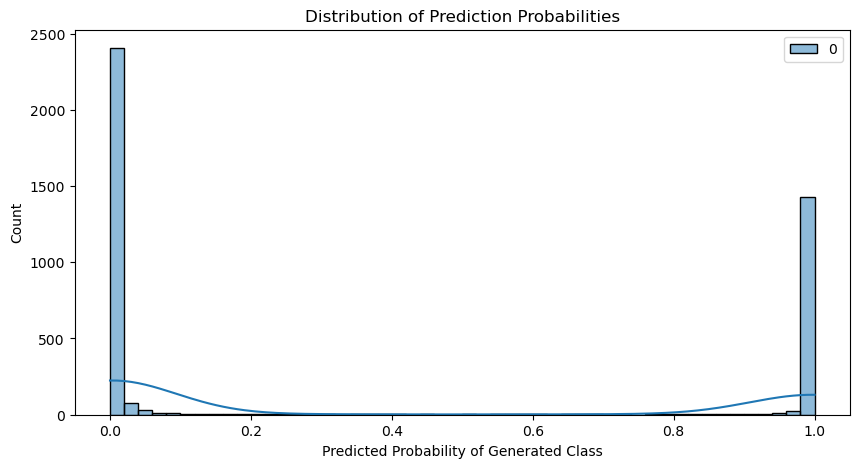

In [63]:
# 5. Distribution of Prediction Probabilities
y_pred_proba = lstm_model_fasttext.predict(X_test_pad)
plt.figure(figsize=(10, 5))
sns.histplot(y_pred_proba, bins=50, kde=True)
plt.xlabel('Predicted Probability of Generated Class')
plt.title('Distribution of Prediction Probabilities')
plt.show()

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D, GlobalAveragePooling1D, Layer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, TFBertForSequenceClassification
import torch
import lime
import lime.lime_text
from lime.lime_text import LimeTextExplainer
import shap
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
from transformers import pipeline
from tensorflow.keras.models import load_model

In [65]:
word_weights = dict(exp.as_list())

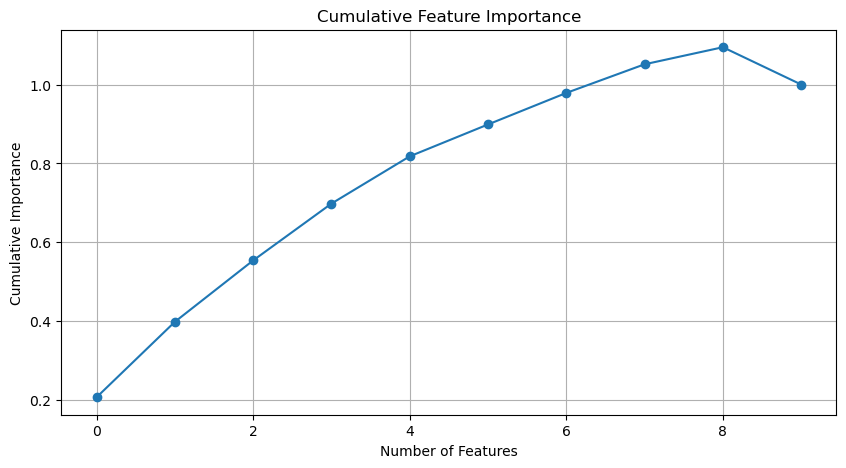

In [66]:
# 6. Cumulative Feature Importance
sorted_weights = sorted(word_weights.values(), reverse=True)
cumulative_importance = np.cumsum(sorted_weights) / np.sum(sorted_weights)
plt.figure(figsize=(10, 5))
plt.plot(cumulative_importance, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


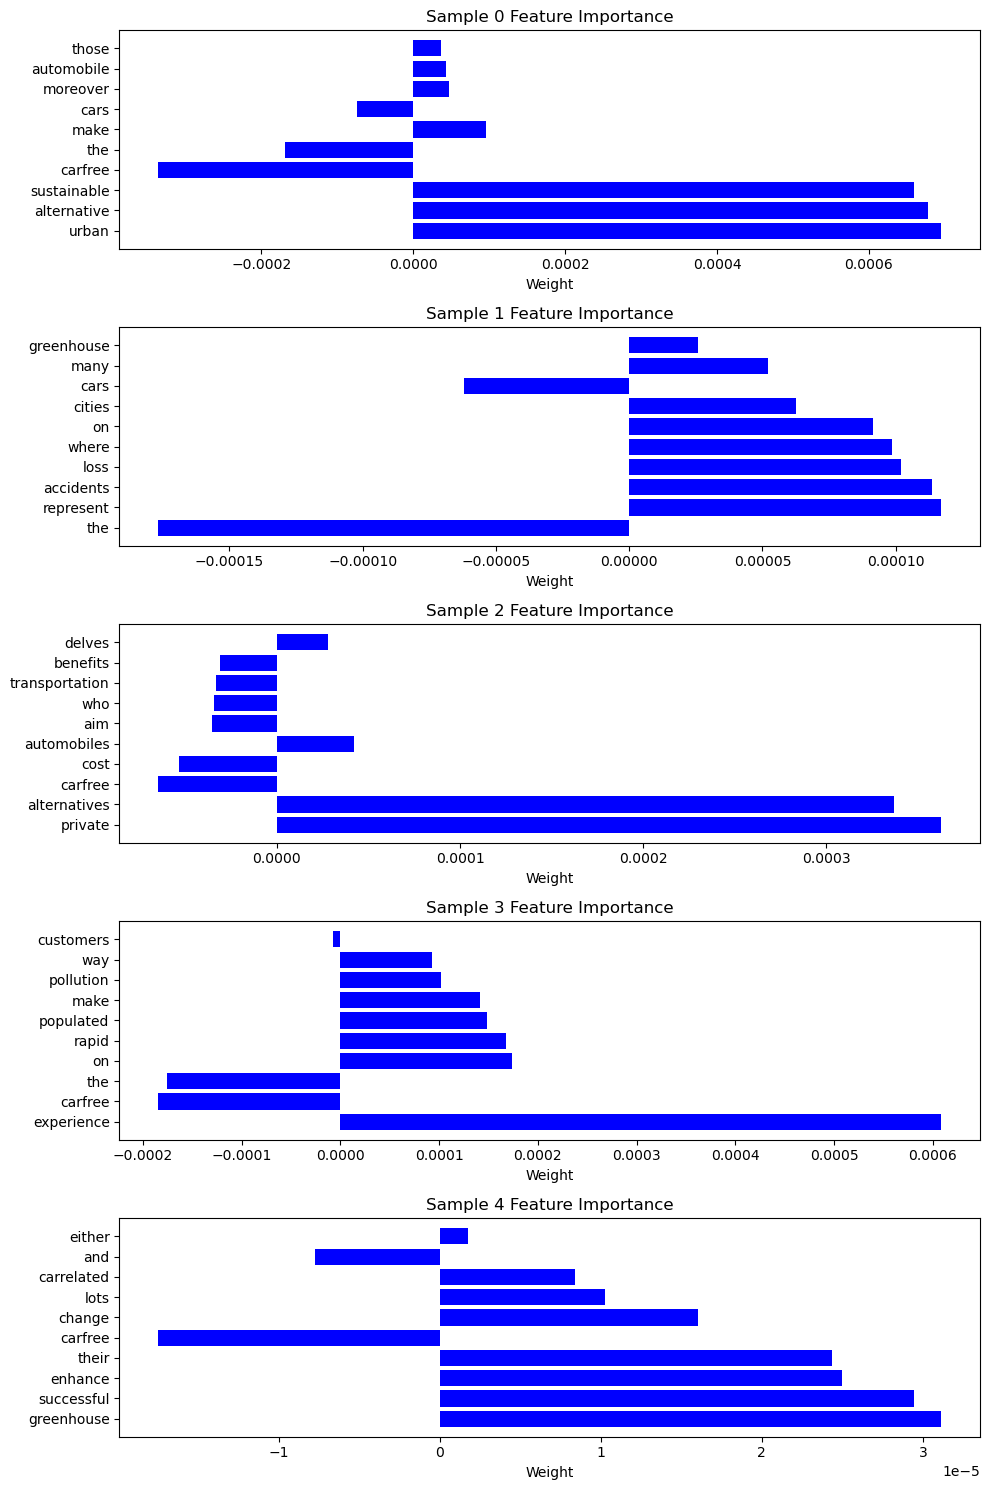

In [67]:
# 7. Feature Contribution Bar Chart for Multiple Samples
num_samples = 5
texts_to_explain = df['clean_text'].iloc[:num_samples]  # Change to select different examples
fig, axes = plt.subplots(num_samples, 1, figsize=(10, 15))
for i, text in enumerate(texts_to_explain):
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    weights = dict(exp.as_list())
    axes[i].barh(list(weights.keys()), list(weights.values()), color='b')
    axes[i].set_title(f'Sample {i} Feature Importance')
    axes[i].set_xlabel('Weight')
fig.tight_layout()
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15

C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


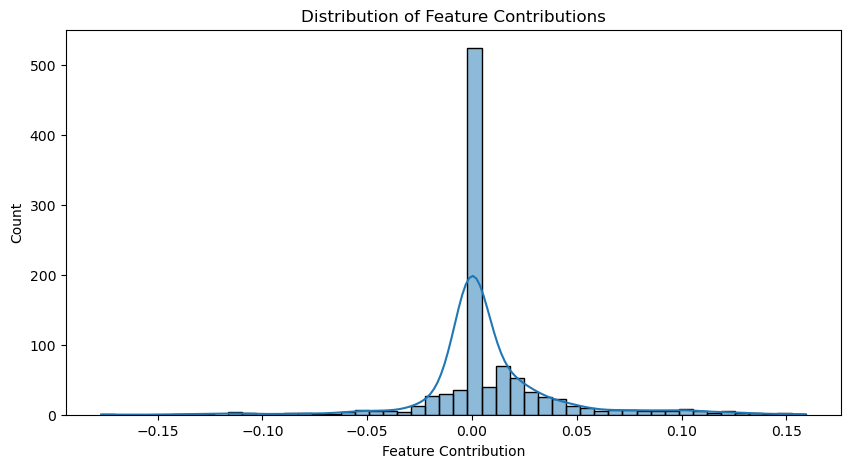

In [68]:
# 9. Feature Contribution Distribution
feature_contributions = []
for text in df['clean_text'].iloc[:100]:  # Change to analyze more samples
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    weights = dict(exp.as_list())
    feature_contributions.extend(list(weights.values()))

plt.figure(figsize=(10, 5))
sns.histplot(feature_contributions, bins=50, kde=True)
plt.xlabel('Feature Contribution')
plt.title('Distribution of Feature Contributions')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


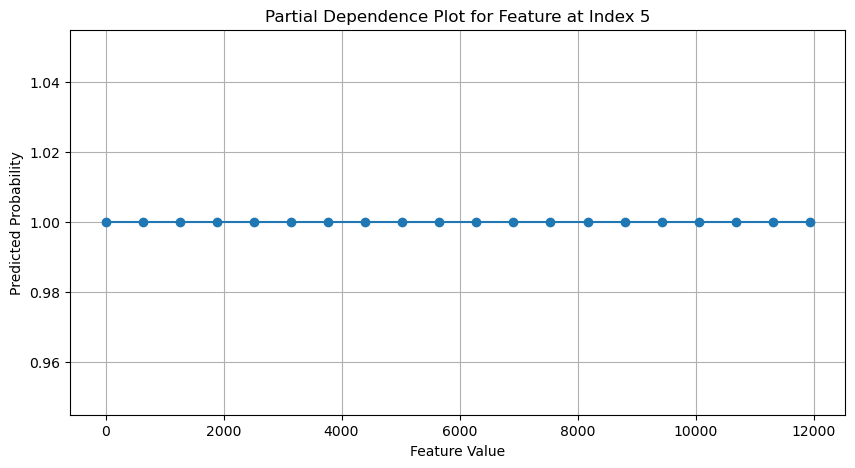

In [69]:
# 10. Partial Dependence Plot
def partial_dependence_plot(text, feature_index):
    seq = tokenizer.texts_to_sequences([text])[0]
    feature_values = np.linspace(0, np.max(seq), num=20).astype(int)
    predictions = []
    for value in feature_values:
        temp_seq = seq.copy()
        temp_seq[feature_index] = value
        padded = tf.keras.preprocessing.sequence.pad_sequences([temp_seq], maxlen=max_sequence_length)
        preds = lstm_model_fasttext.predict(padded)
        predictions.append(preds[0][0])
    
    plt.figure(figsize=(10, 5))
    plt.plot(feature_values, predictions, marker='o')
    plt.xlabel('Feature Value')
    plt.ylabel('Predicted Probability')
    plt.title(f'Partial Dependence Plot for Feature at Index {feature_index}')
    plt.grid()
    plt.show()

partial_dependence_plot(text_to_explain, 5)  # Change the feature index to analyze different features


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


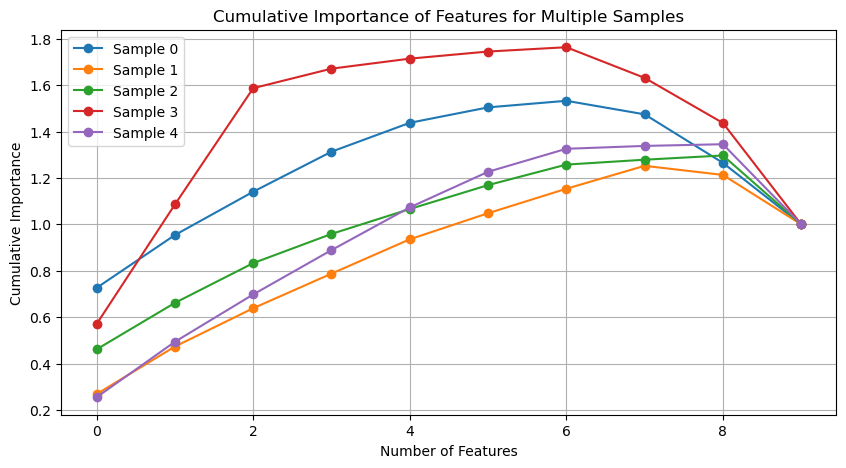

In [70]:
# 11. Cumulative Importance of Features for Multiple Samples
num_samples = 5
texts_to_explain = df['clean_text'].iloc[:num_samples]  # Change to select different examples
cumulative_importances = []
for text in texts_to_explain:
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    weights = sorted(dict(exp.as_list()).values(), reverse=True)
    cumulative_importance = np.cumsum(weights) / np.sum(weights)
    cumulative_importances.append(cumulative_importance)

plt.figure(figsize=(10, 5))
for i, cum_importance in enumerate(cumulative_importances):
    plt.plot(cum_importance, marker='o', label=f'Sample {i}')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importance of Features for Multiple Samples')
plt.legend()
plt.grid()
plt.show()